In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/sebastian/masters/') # add my repo to python path
import os
import torch
import torch_geometric
import kmbio  # fork of biopython PDB with some changes in how the structure, chain, etc. classes are defined.
import numpy as np
import proteinsolver
import modules

from pathlib import Path
from modules.dataset import *
from modules.utils import *
from modules.model import *
from modules.my_model import *

np.random.seed(1)

### Load positive examples and generate different structure configurations

In [3]:
root = Path("/home/sebastian/masters/data/")
data_root = root / "neat_data"
metadata_path = data_root / "embedding_dataset.csv"


class ChainFilter(kmbio.PDB.Select):
    def __init__(self, subset):
        self.subset = subset

    def accept_chain(self, chain):
        if chain.id in self.subset:
            return 1
        else:
            return 0

overwrite = False

raw_files, targets = get_data(
    model_dir=data_root / "raw" / "tcrpmhc",
    metadata=data_root / "metadata.csv",
)
mask = np.ma.masked_array(raw_files, mask=targets)  # only get positives

pmhc_chain_subset = ["M", "P"]
p_chain_subset = ["P"]
annotated_paths = list()

outdir_1 = data_root / "raw" / "pmhc"
outdir_2 = data_root / "raw" / "p"

outdir_1.mkdir(parents=True, exist_ok=True)
outdir_2.mkdir(parents=True, exist_ok=True)
for raw_file in raw_files[mask.mask]:

    model_id = raw_file.name.split("_")[0]
    pmhc_file_name = outdir_1 / f"{model_id}_pmhc.pdb"
    p_file_name =  outdir_2/ f"{model_id}_p.pdb"
    
    if overwrite or (not pmhc_file_name.is_file() or not p_file_name.is_file()):
        structure  = kmbio.PDB.load(raw_file)
    
        io = kmbio.PDB.io.PDBIO()
        io.set_structure(structure)
        io.save(pmhc_file_name, ChainFilter(subset=pmhc_chain_subset))
    
        io = kmbio.PDB.io.PDBIO()
        io.set_structure(structure)
        io.save(p_file_name, ChainFilter(subset=p_chain_subset))

    annotated_paths.append([raw_file, "0"])  # add indices of peptide
    annotated_paths.append([pmhc_file_name, "1"])  # add indices of peptide
    annotated_paths.append([p_file_name, "2"])  # add indices of peptide

with open(metadata_path, "w") as metadata_outfile:
    for data in annotated_paths:
        print(data[0], data[1], sep=",", file=metadata_outfile)

### Define and tune classifier

In [4]:
from sklearn.model_selection import KFold
from sklearn.metrics import *
from torch import nn, optim
import torch.nn.functional as F


root = Path("/home/sebastian/masters/data/")
data_root = root / "neat_data"
metadata_path = data_root / "embedding_dataset.csv"
processed_dir = data_root / "processed" / "embedding_verification"
state_file = root / "state_files" / "e53-s1952148-d93703104.state"
out_dir = root / "state_files" / "embedding_verification" 

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# load dataset
raw_files = list()
targets = list()
with open(metadata_path, "r") as infile:
    for line in infile:
        line = line.strip().split(",")
        raw_files.append(line[0])
        targets.append(int(line[1]))

raw_files = np.array(raw_files)
targets = np.array(targets)

dataset = ProteinDataset(processed_dir, raw_files, targets, overwrite=False)

# init proteinsolver gnn
num_features = 20
adj_input_size = 2
hidden_size = 128

gnn = Net(
    x_input_size=num_features + 1, 
    adj_input_size=adj_input_size, 
    hidden_size=hidden_size, 
    output_size=num_features
)
gnn.load_state_dict(torch.load(state_file, map_location=device))
gnn.eval()
gnn = gnn.to(device)

# init LSTM
num_classes = 3
num_layers = 2
hidden_size = 26

net = MyLSTM(num_classes, num_features, num_layers, hidden_size)
net = net.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001) 

# training params
epochs = 1
n_splits = 5
batch_size = 5

# touch files to ensure output
save_dir = get_non_dupe_dir(out_dir)
loss_paths = touch_output_files(save_dir, "loss", n_splits)
state_paths = touch_output_files(save_dir, "state", n_splits)
pred_paths = touch_output_files(save_dir, "pred", n_splits)

CV = KFold(n_splits=n_splits, shuffle=True)
i = 0
for train_idx, valid_idx in CV.split(dataset):
    
    train_subset = dataset[torch.LongTensor(train_idx)][0:10]
    valid_subset = dataset[torch.LongTensor(valid_idx)][0:10]
    
    net = MyLSTM(num_classes, num_features, num_layers, hidden_size)
    net = net.to(device)
    
    # partial function - gnn arg is static, x is given later
    gnn_transform = lambda x: gnn_to_lstm_batch(
        x, 
        gnn_instance=gnn, 
        device=device,
        num_classes=num_classes
)
    
    net, train_subset_losses, valid_subset_losses = train_model(
        model=net,
        epochs=epochs, 
        criterion=criterion,
        optimizer=optimizer,
        train_data=train_subset, 
        valid_data=valid_subset,
        batch_size=batch_size,
        device=device,
        transform=gnn_transform,
)

    torch.save({"train": train_subset_losses, "valid": valid_subset_losses}, loss_paths[i])
    torch.save(net.state_dict(), state_paths[i])
    
    # perform test preds
    y_pred, y_true = predict(
        model=net, 
        data=train_subset, 
        batch_size=batch_size,
        device=device,
        transform=gnn_transform,
)

    torch.save({"y_pred": y_pred, "y_true": y_true,}, pred_paths[i])
    
    i += 1


epoch: 1 - n: 2/2 - [========================================================100%]


In [5]:
# compute performance
labels = ["TCRpMHC", "pMHC", "p"]
performance_data = dict()
for i in range(n_splits):
    data = torch.load(pred_paths[i])
    y_pred = data["y_pred"]
    y_true = data["y_true"]
    
    # confusion matrix
    y_pred_max = torch.argmax(y_pred, dim=1, keepdim=True)
    y_true_idx = torch.argmax(y_true, dim=1, keepdim=True)
    cm = confusion_matrix(y_true_idx, y_pred_max)

    # f1
    f1 = f1_score(y_pred_max, y_true_idx, average="weighted")

    # multiclass auc
    auc = roc_auc_score(y_true, y_pred, multi_class="ovr", average="weighted")

    output = {
        "f1": f1,
        "auc": auc,
        "cm": cm,
        "labels": labels
    }
    performance_data[i] = output

torch.save(performance_data, save_dir / "performance_data.pt")

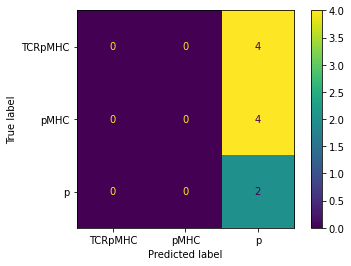

In [7]:
disp = ConfusionMatrixDisplay(cm, display_labels=["TCRpMHC", "pMHC", "p"])
disp.plot()